# **Time Series Prediction with LSTM Using PyTorch**

This kernel is based on *datasets* from

[Time Series Forecasting with the Long Short-Term Memory Network in Python](https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/)

[Time Series Prediction with LSTM Recurrent Neural Networks in Python with Keras](https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/)

## Reference
- https://colab.research.google.com/github/dlmacedo/starter-academic/blob/master/content/courses/deeplearning/notebooks/pytorch/Time_Series_Prediction_with_LSTM_Using_PyTorch.ipynb

## **Import Packages**

In [1]:
# For data preprocess
import os
import csv
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from functools import reduce

# For plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# Pytorch
import torch
import torch.nn as nn
from torch.autograd import Variable

## **Set Random Seed**

In [2]:
def same_seeds(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  
    np.random.seed(seed)  
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

## **Get GPU Resource**

In [3]:
def get_device():
    ''' Get device (if GPU is available, use GPU) '''
    return 'cuda' if torch.cuda.is_available() else 'cpu'
device = get_device()
print(device)

cpu


## **Setup Hyper-parameters**

In [4]:
# dataset
infected_data_path = os.path.join('..', 'data', 'timeline_diagnosed.csv')
population_data_path = os.path.join('..', 'data', 'population.csv')

# data selection
seq_length = 7  # X(seq_length) + Y(1)

start_date = "2022-03-10"
end_date   = "2022-06-01"
delta_date = datetime.strptime(end_date, "%Y-%m-%d") - datetime.strptime(start_date, "%Y-%m-%d")
data_size = delta_date.days + 1 - seq_length
print(data_size)
test_size = 3
train_size = data_size - test_size
test_start_date = (pd.to_datetime(end_date) + pd.DateOffset(days=(-test_size+1))).strftime("%Y-%m-%d")
start_date_y = (pd.to_datetime(start_date) + pd.DateOffset(days=(seq_length))).strftime("%Y-%m-%d")

pred_long_size = 14

city_codes = ["KEE", "NWT", "TPE", "TAO", "HSZ", "HSQ", "MIA", "TXG", "CHA", "NAN", "YUN", "CYQ", "CYI", "TNN", "KHH", "PIF", "ILA", "HUA", "TTT", "PEN", "KIN", "LIE"]
cityGroups = [
    ["KEE"], 
    ["NWT"], 
    ["TPE", "TAO"], 
    ['TXG', 'TNN', 'KHH'], 
    ['HSZ', 'HSQ', 'MIA', 'CHA', 'NAN', 'YUN', 'CYQ', 'CYI', 'PIF', 'ILA', 'HUA', 'TTT', 'PEN', 'KIN', 'LIE']
]
cityMapping = {i:[] for i in city_codes}
for group in cityGroups:
    for city in group:
        tmpGroup = group.copy()
        tmpGroup.remove(city)
        cityMapping[city] = tmpGroup
# cityMapping["KEE"] = []
# cityMapping["NWT"] = []
# cityMapping["TPE"] = ["TAO"]
# cityMapping['TXG'] = ['TNN', 'KHH']
# cityMapping['HSZ'] = ['HSQ', 'MIA', 'CHA', 'NAN', 'YUN', 'CYQ', 'CYI', 'PIF', 'ILA', 'HUA', 'TTT', 'PEN', 'KIN', 'LIE']


# model parameters
num_epochs = 12000
early_stop = 4000
learning_rate = 0.01

input_size = 1
hidden_size = 3
num_layers = 1
num_classes = 1

criterion = torch.nn.MSELoss()    # mean-squared error for regression
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# save model
model_dir = os.path.join('..', 'models', 'LSTM-multivariate')
os.makedirs(model_dir, exist_ok=True)
save_path = os.path.join('..', 'models', 'LSTM-multivariate', 'model-{}.pth')

# others
seed = 20220605

77


## **Check Raw Data**

In [5]:
dataset = pd.read_csv(infected_data_path)
print(dataset)
print(dataset[dataset['city']=='LIE'])

      city        date  count  accumulateCount
0      KEE  2020-01-28      0                0
1      NWT  2020-01-28      0                0
2      TPE  2020-01-28      0                0
3      TAO  2020-01-28      0                0
4      HSZ  2020-01-28      0                0
...    ...         ...    ...              ...
19821  TTT  2022-06-07    933            19838
19822  PEN  2022-06-07    314             4353
19823  KIN  2022-06-07     99             3191
19824  LIE  2022-06-07     57              843
19825   TW  2022-06-07  80184          2606905

[19826 rows x 4 columns]
      city        date  count  accumulateCount
21     LIE  2020-01-28      0                0
44     LIE  2020-01-29      0                0
67     LIE  2020-01-30      0                0
90     LIE  2020-01-31      0                0
113    LIE  2020-02-01      0                0
...    ...         ...    ...              ...
19732  LIE  2022-06-03     24              723
19755  LIE  2022-06-04     13     

In [6]:
populationDf=pd.read_csv(population_data_path)
print(populationDf.head(5))

  Region        area  numCity  numVillage  numNeighborhood  numHouse  \
0     TW  36197.0669      368        7746           142480   9002584   
1    NWT   2052.5667       29        1032            22150   1620113   
2    TPE    271.7997       12         456             9572   1043569   
3    TAO   1220.9540       13         516            11930    863712   
4    TXG   2214.8968       29         625            12517   1020026   

   population      male    female  sexRatio  densityArea  densityHouse  
0    23215015  11493738  11721277     98.06       641.35          2.58  
1     3975803   1940507   2035296     95.34      1936.99          2.45  
2     2478124   1179782   1298342     90.87      9117.46          2.37  
3     2263430   1119790   1143640     97.91      1853.82          2.62  
4     2801069   1373848   1427221     96.26      1264.65          2.75  


In [7]:
def get_city_data(dataset, city):
    mask = ((dataset["city"] == city) & (dataset["date"] >= start_date) & (dataset["date"] <= end_date))
    city_dataset = dataset[mask]["count"].values.reshape(-1, 1)
    # print(city_dataset)

    # plt.plot(city_dataset, label = 'COVID-19 New Cases')
    # plt.show()
    return city_dataset

## **Preprocessing**

In [8]:
'''
Compute more features for multivariate LSTM
1. rolling window(7 days, 14 days)
2. mortality data, confirmed data
3. density(confirmed density with area or population)
4. other cities' data(city-wise data in to column)
Note, use standardization instead of normalization. Since 'density' features are just dividing some scalar
或者normalization是要對所有縣市的所有天數的feature一起計算
'''
def computeFeatures(confirmedDataset: pd.DataFrame, populationDataset, cityName='NWT'):
  singleCityConfirmedDataset = confirmedDataset[confirmedDataset['city']==cityName].copy()
  # singleCityConfirmedDataset.drop(columns=['city'], inplace=True)
  # Confirmed ratio
  cityInfo = populationDataset[populationDataset['Region']==cityName]
  cityPopulation = cityInfo['population'].values[0]
  cityArea = cityInfo['area'].values[0]
  singleCityConfirmedDataset['densityPop'] = singleCityConfirmedDataset['count'] / cityPopulation
  singleCityConfirmedDataset['densityArea'] = singleCityConfirmedDataset['count'] / cityArea
  # Rolling average
  singleCityConfirmedDataset['countRoll7'] = singleCityConfirmedDataset['count'].rolling(7, closed='left').sum().fillna(0)  # Assume the series begining with 0 confirmed case
  # singleCityConfirmedDataset['countRoll14'] = singleCityConfirmedDataset['count'].rolling(14, closed='left').sum().fillna(0)  
  singleCityConfirmedDataset['densPopRoll7'] = singleCityConfirmedDataset['densityPop'].rolling(7, closed='left').sum().fillna(0)  
  # singleCityConfirmedDataset['densPopRoll14'] = singleCityConfirmedDataset['densityPop'].rolling(14, closed='left').sum().fillna(0)  
  singleCityConfirmedDataset['densAreaRoll7'] = singleCityConfirmedDataset['densityArea'].rolling(7, closed='left').sum().fillna(0)  
  # singleCityConfirmedDataset['densAreaRoll14'] = singleCityConfirmedDataset['densityArea'].rolling(14, closed='left').sum().fillna(0)  
  # print(singleCityConfirmedDataset.iloc[0:30, :])
  return singleCityConfirmedDataset

In [9]:
'''
# 1. Stack all the city-wise features, and normalize each feature(except 'city')
# 2. Separate data into city-wise series
'''
def featurePreproc(confirmedDf, populationDf):
  confirmedDf = confirmedDf.copy()
  confirmedDf.loc[:, 'date']=pd.to_datetime(confirmedDf['date'], format='%Y-%m-%d')
  confirmedDf.set_index('date', inplace=True)
  confirmedDf = confirmedDf[(confirmedDf.index>=start_date)&(confirmedDf.index<=end_date)]
  confirmedDf = confirmedDf.drop(columns=['accumulateCount'])

  # 1. Stack all the city-wise features, and normalize each feature(except 'city')
  cityWiseFeaturesDfs = []
  for _aCity in city_codes:
    cityWiseFeaturesDfs.append(
        computeFeatures(confirmedDf, populationDf, cityName=_aCity)
    )
  augFeatures = pd.concat(cityWiseFeaturesDfs)
  ## Normalize
  minmaxNorm = MinMaxScaler()
  onlyFeatures = minmaxNorm.fit_transform(augFeatures.drop(columns=['city']).values)
  onlyFeatures = np.hstack((augFeatures['city'].values[:, None], onlyFeatures))

  df = pd.DataFrame(
      onlyFeatures, 
      columns=augFeatures.columns, 
      index=augFeatures.index
  )
  # 2. Separate data into city-wise series
  cityWiseDfs = []
  cityWiseDfsDict = {}
  for _aCity in city_codes:
    cityWiseDfs.append(
        df[df['city']==_aCity].drop(columns=['city']).rename(columns={colNm: colNm+'_'+_aCity for colNm in df.columns})
    )
    cityWiseDfsDict[_aCity]=df[df['city']==_aCity].drop(columns=['city'])
  mergedDf = reduce(lambda x, y: pd.concat([x, y], axis=1), cityWiseDfs)
  return mergedDf, cityWiseDfsDict, minmaxNorm

mergedDf, cityWiseData, minmaxNorm = featurePreproc(dataset, populationDf)

In [10]:
'''
根據預測目標的城市，給予相應的資料(其他城市的資料)
目標城市的確診數需要在第一個column
整理成numpy.array型態
Ref: https://stackoverflow.com/questions/56858924/multivariate-input-lstm-in-pytorch
'''
def cityWiseDataPreproc(cityWiseData, targetCity, correspondingCities):
  cities = [targetCity] + correspondingCities
  dfs = [cityWiseData[k] for k in cities]
  mergedDf = reduce(lambda x, y: pd.concat([x, y], axis=1), dfs)
  return mergedDf
# preprocData = cityWiseDataPreproc(cityWiseData, 'NWT', ['TPE', 'KEE', 'TAO'])
preprocData = cityWiseDataPreproc(cityWiseData, 'NWT', [])
preprocData.iloc[-7:, :]

,count,densityPop,densityArea,countRoll7,densPopRoll7,densAreaRoll7
date,,,,,,
2022-05-26,0.730967,0.730967,0.246535,0.868335,0.868335,0.27434
2022-05-27,0.598348,0.598348,0.201806,0.84593,0.84593,0.267262
2022-05-28,0.556977,0.556977,0.187853,0.801465,0.801465,0.253213
2022-05-29,0.402214,0.402214,0.135656,0.766596,0.766596,0.242197
2022-05-30,0.539789,0.539789,0.182056,0.737515,0.737515,0.233009
2022-05-31,0.557258,0.557258,0.187948,0.724534,0.724534,0.228908
2022-06-01,0.483445,0.483445,0.163053,0.684334,0.684334,0.216207


In [11]:
def data_preprocess(city_dataset):
    def sliding_windows(data, seq_length):
        x = []
        y = []
        for i in range(data_size):
            _x = data[i:(i+seq_length), :]
            _y = data[i+seq_length, :]
            x.append(_x)
            y.append(_y)

        return np.array(x),np.array(y)

    sc = MinMaxScaler()
    # city_data = sc.fit_transform(city_dataset)
    city_data = city_dataset.astype(float)
    x, y = sliding_windows(city_data, seq_length)

    dataX = Variable(torch.Tensor(np.array(x)))
    dataY = Variable(torch.Tensor(np.array(y)))

    train_indices = [i for i in range(train_size) if i%10 != 7]
    val_indices = [i for i in range(train_size) if i%10 == 7]

    trainX = Variable(torch.Tensor(np.array(x[train_indices])))
    trainY = Variable(torch.Tensor(np.array(y[train_indices])))

    valX = Variable(torch.Tensor(np.array(x[val_indices])))
    valY = Variable(torch.Tensor(np.array(y[val_indices])))

    testX = Variable(torch.Tensor(np.array(x[(train_size): len(x)])))
    testY = Variable(torch.Tensor(np.array(y[(train_size): len(y)])))

    # trainY = trainY.view((len(trainY), 1))
    # valY = valY.view((len(valY), 1))
    # testY = testY.view((len(testY), 1))

    return sc, dataX, dataY, trainX, trainY, valX, valY, testX, testY

_, _, _, trainX, trainY, valX, valY, _, _ = data_preprocess(preprocData.values)
print(trainX.shape)
print(trainY.shape)
print(trainX[-1, -1, :])
print(trainY[-1, :])
print(minmaxNorm.inverse_transform(trainY[-1, :][np.newaxis, :]))

torch.Size([67, 7, 6])
torch.Size([67, 6])
tensor([0.5570, 0.5570, 0.1879, 0.8015, 0.8015, 0.2532])
tensor([0.4022, 0.4022, 0.1357, 0.7666, 0.7666, 0.2422])
[[1.14429999e+04 2.87816069e-03 5.57497125e+00 1.28853998e+05
  3.24095531e-02 6.27770113e+01]]


## **Model**
LSTM + fully connected layer

In [12]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size * num_layers, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, 
            x.size(0), 
            self.hidden_size,
            device=device))
        
        c_0 = Variable(torch.zeros(
            self.num_layers,
            x.size(0),
            self.hidden_size,
            device=device))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size * self.num_layers)
        
        out = self.fc(h_out)
        
        return out

# **Train/Test**

## **Training**

In [13]:
def train(city, model, trainX, trainY, valX, valY):
    min_loss = np.infty
    loss_record = {'train': [], 'val': []}
    early_stop_cnt = 0
    _trainX, _trainY = trainX.to(device), trainY.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()

        pred = model(_trainX)
        
        # obtain the loss function
        loss = criterion(pred, _trainY)
        loss.backward()
        optimizer.step()
        loss_record['train'].append(loss.detach().cpu().item())

        val_loss = val(model, valX, valY)
        if val_loss < min_loss:
            min_loss = val_loss
            # print('Saving {} model (epoch = {:4d}, val loss = {:.4f})'
            #     .format(city, epoch + 1, min_loss))
            torch.save(model.state_dict(), save_path.format(city))
            early_stop_cnt = 0
        else:
            early_stop_cnt += 1

        loss_record['val'].append(val_loss)

        if (epoch+1) % 100 == 0:
            print("Epoch: %d, loss: %1.5f, %1.5f" % (epoch+1, loss.item(), val_loss))
        if early_stop_cnt > early_stop:
            break
    
    return min_loss, loss_record

## **Validation**

In [14]:
def val(model, valX, valY):
    model.eval()
    _valX, _valY = valX.to(device), valY.to(device)
    with torch.no_grad():
        pred = model(_valX)
        loss = criterion(pred, _valY)
    total_loss = loss.detach().cpu().item()

    return total_loss

## **Train for Cities**

In [15]:
loss_record = {}

for city in city_codes:
    same_seeds(seed)
    print(f"===== {city} =====")
    # city_dataset = get_city_data(dataset, city)
    # _, _, _, trainX, trainY, valX, valY, _, _ = data_preprocess(city_dataset)
    preprocData = cityWiseDataPreproc(cityWiseData, city, cityMapping[city])
    _, _, _, trainX, trainY, valX, valY, _, _ = data_preprocess(preprocData.values)
    input_size = preprocData.values.shape[1]
    num_classes = preprocData.values.shape[1]
    # print(trainX.shape)
    # print(trainY.shape)
    # print(preprocData.values.shape)
    # print(len(cityMapping[city]))
    # break
    
    lstm = LSTM(num_classes, input_size, hidden_size, num_layers).to(device)

    city_min_loss, city_loss_record = train(city, lstm, trainX, trainY, valX, valY)
    print(f"{city}: min_loss = {city_min_loss}")
    loss_record[city] = city_loss_record
    del lstm

===== KEE =====
Epoch: 100, loss: 0.00412, 0.00258
Epoch: 200, loss: 0.00165, 0.00038
Epoch: 300, loss: 0.00145, 0.00041
Epoch: 400, loss: 0.00125, 0.00048
Epoch: 500, loss: 0.00111, 0.00058
Epoch: 600, loss: 0.00104, 0.00063
Epoch: 700, loss: 0.00100, 0.00062
Epoch: 800, loss: 0.00098, 0.00061
Epoch: 900, loss: 0.00096, 0.00059
Epoch: 1000, loss: 0.00094, 0.00056
Epoch: 1100, loss: 0.00092, 0.00055
Epoch: 1200, loss: 0.00090, 0.00053
Epoch: 1300, loss: 0.00089, 0.00052
Epoch: 1400, loss: 0.00087, 0.00050
Epoch: 1500, loss: 0.00086, 0.00049
Epoch: 1600, loss: 0.00085, 0.00048
Epoch: 1700, loss: 0.00083, 0.00047
Epoch: 1800, loss: 0.00082, 0.00047
Epoch: 1900, loss: 0.00081, 0.00046
Epoch: 2000, loss: 0.00079, 0.00046
Epoch: 2100, loss: 0.00078, 0.00045
Epoch: 2200, loss: 0.00076, 0.00045
Epoch: 2300, loss: 0.00075, 0.00045
Epoch: 2400, loss: 0.00073, 0.00045
Epoch: 2500, loss: 0.00070, 0.00045
Epoch: 2600, loss: 0.00067, 0.00045
Epoch: 2700, loss: 0.00063, 0.00047
Epoch: 2800, loss: 0.

## **Training and Validation Loss**

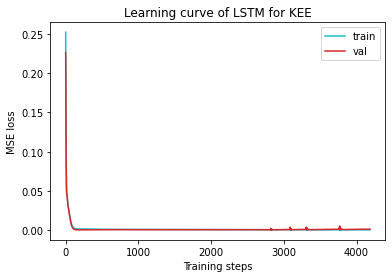

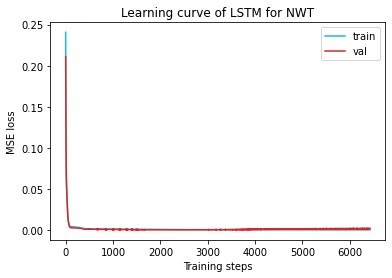

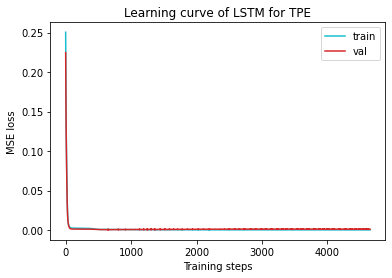

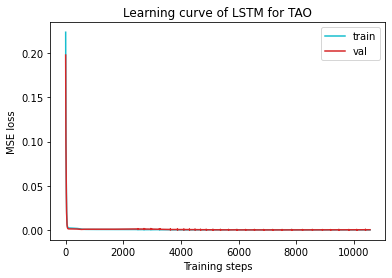

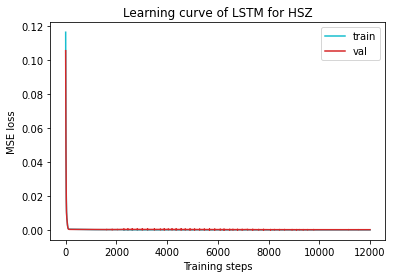

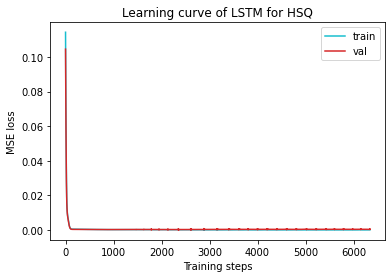

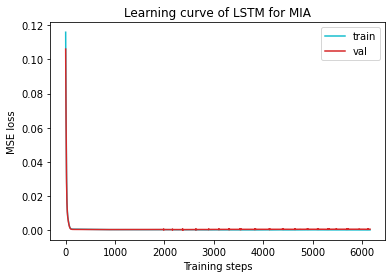

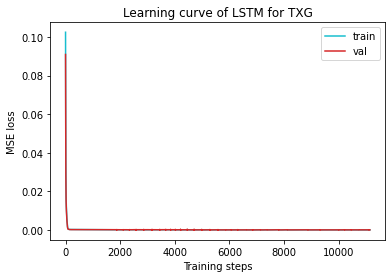

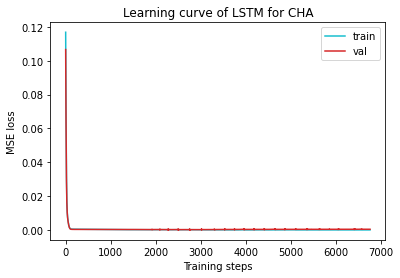

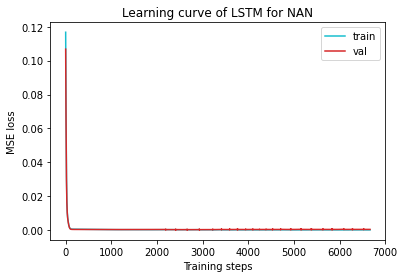

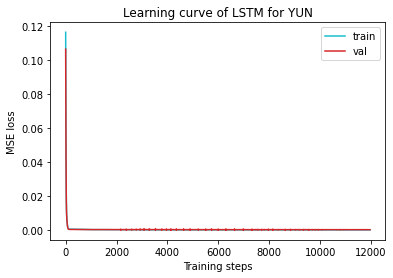

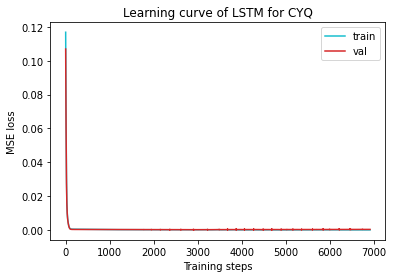

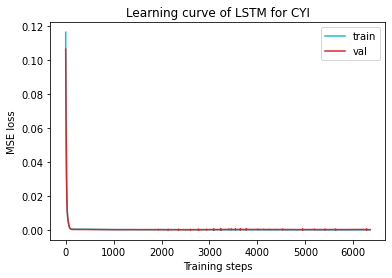

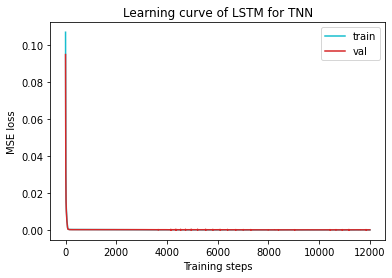

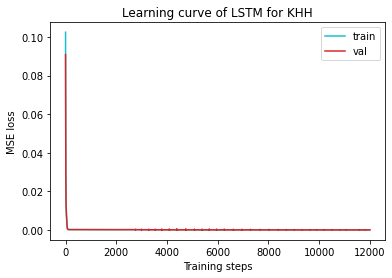

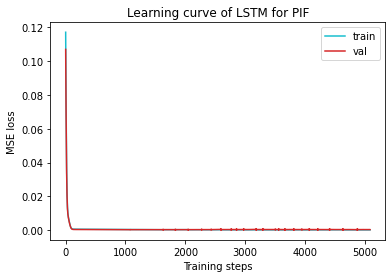

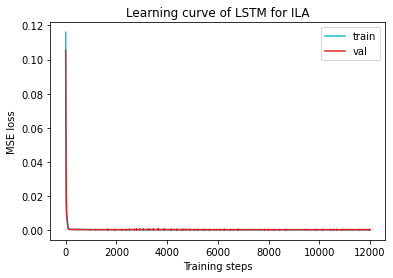

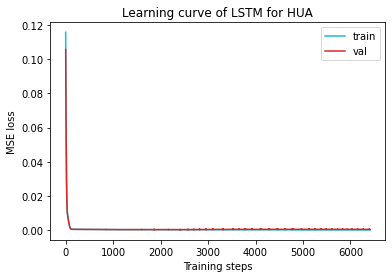

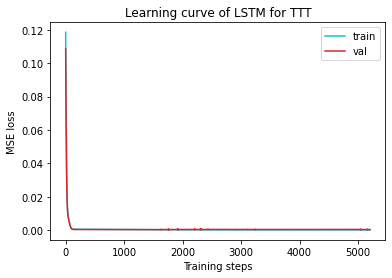

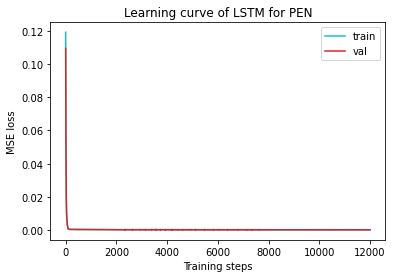

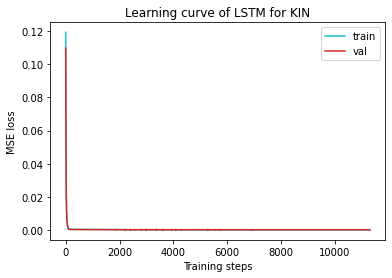

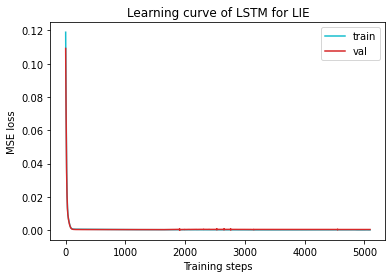

In [16]:
for city in city_codes:
    total_steps = len(loss_record[city]['train'])
    x_1 = range(total_steps)
    x_2 = x_1[::len(loss_record[city]['train']) // len(loss_record[city]['val'])]
    figure(figsize=(6, 4))
    plt.plot(x_1, loss_record[city]['train'], c='tab:cyan', label='train')
    plt.plot(x_2, loss_record[city]['val'], c='tab:red', label='val')
    plt.xlabel("Training steps")
    plt.ylabel("MSE loss")
    plt.title(f"Learning curve of LSTM for {city}")
    plt.legend()
    plt.show()

## **Testing**

Define plotting function.

In [17]:
def plot_predict(city, data_type, pred, real, start_date):
    plt.plot(pred)
    plt.plot(real)
    plt.suptitle(f"Time-Series Prediction for {city} {data_type}")
    plt.xlabel(f"Time (days) from {start_date}")
    plt.ylabel("Number of New Cases")
    plt.legend(("predicted", "real"))

    if data_type == "Data":
        plt.axvline(x=(train_size-1), c='red', linestyle=':')
    plt.show()

Test for each city and plot it.

In [18]:
def test(city, model, X, Y):
    model.eval()
    _X, _Y = X.to(device), Y.to(device)
    test_predict = model(_X)
    loss = criterion(test_predict, _Y)

    return test_predict.detach().cpu(), loss.item()

In [19]:
def printPredError(pred, real):
    # RMSE
    print(f"RMSE: {np.sqrt(np.mean(np.power(pred - real, 2))):.2f}")
    # MAPE
    print(f"MAPE: {np.mean(np.abs(real - pred) / real) * 100:.2f}%")

===== KEE =====
real & predicted test loss: 0.013154743675841019


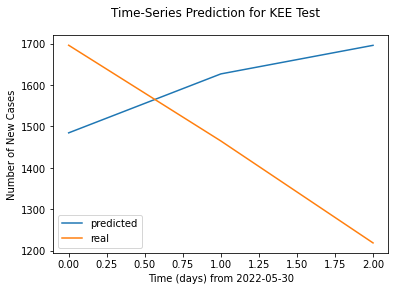

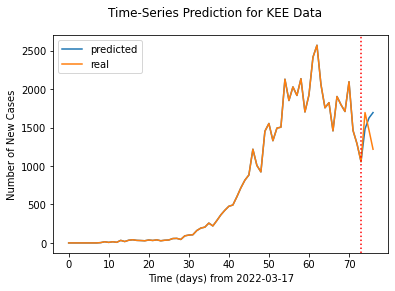

RMSE: 315.27
MAPE: 20.87%
===== NWT =====
real & predicted test loss: 0.0075932733016088605


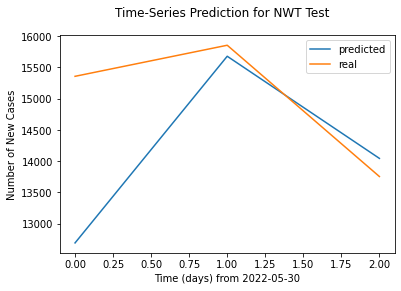

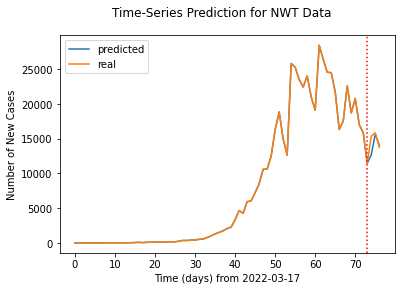

RMSE: 1551.05
MAPE: 6.86%
===== TPE =====
real & predicted test loss: 0.0051060826517641544


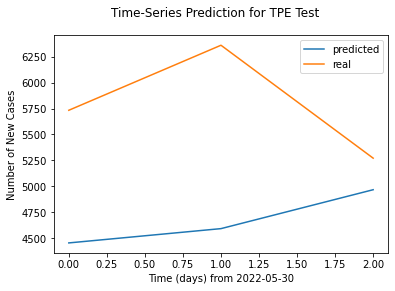

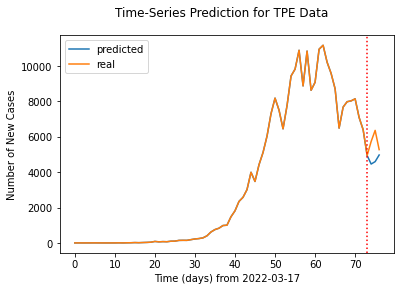

RMSE: 1270.04
MAPE: 18.60%
===== TAO =====
real & predicted test loss: 0.28238397650420666


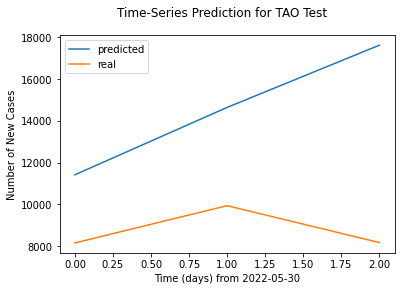

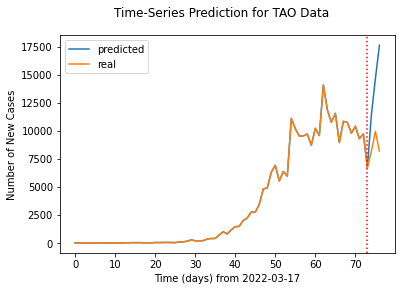

RMSE: 6368.66
MAPE: 67.50%
===== HSZ =====
real & predicted test loss: 0.03794525004923344


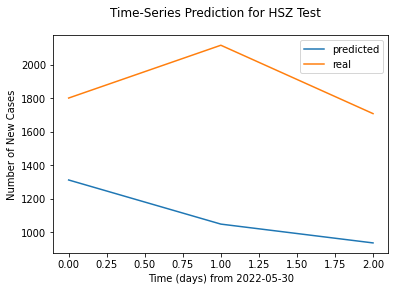

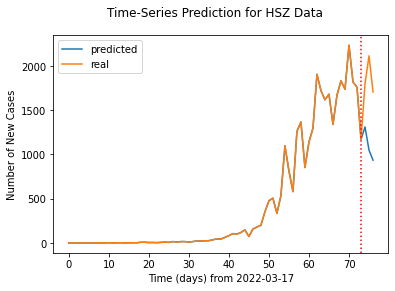

RMSE: 810.98
MAPE: 40.94%
===== HSQ =====
real & predicted test loss: 0.009727408178150654


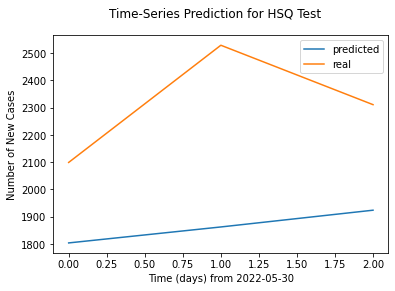

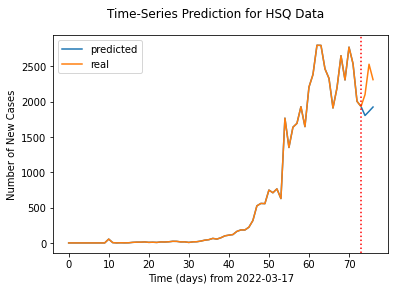

RMSE: 476.69
MAPE: 19.06%
===== MIA =====
real & predicted test loss: 0.009720284258946776


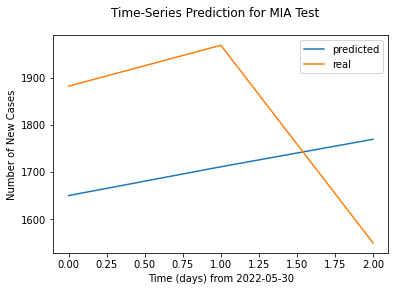

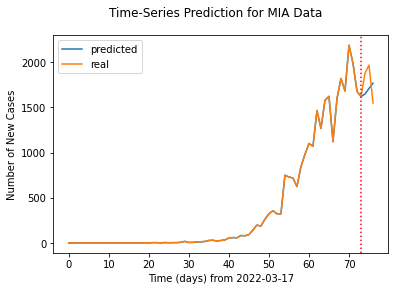

RMSE: 237.45
MAPE: 13.23%
===== TXG =====
real & predicted test loss: 0.16812216117978096


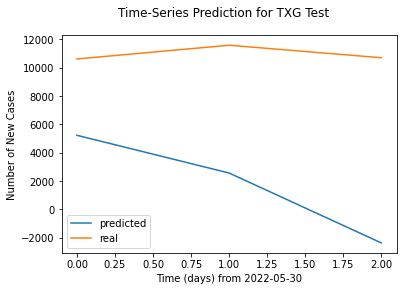

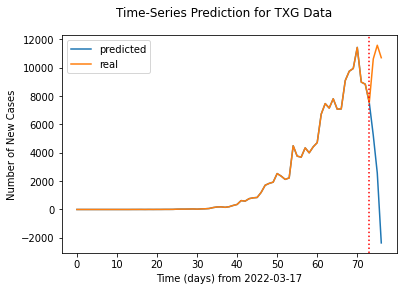

RMSE: 9681.32
MAPE: 83.51%
===== CHA =====
real & predicted test loss: 0.013159512542188168


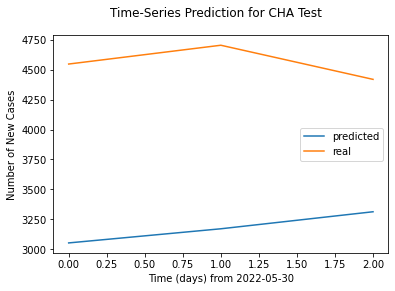

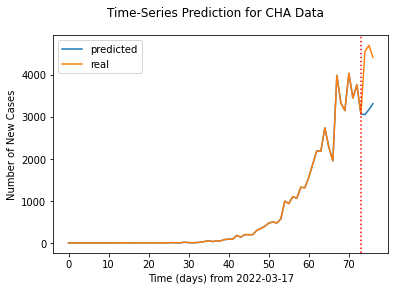

RMSE: 1391.16
MAPE: 30.16%
===== NAN =====
real & predicted test loss: 0.014165269443765283


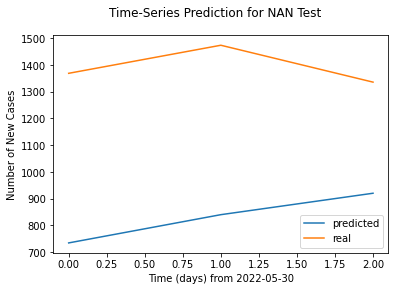

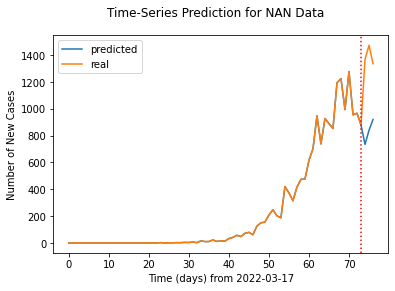

RMSE: 570.68
MAPE: 40.15%
===== YUN =====
real & predicted test loss: 0.03760889684781432


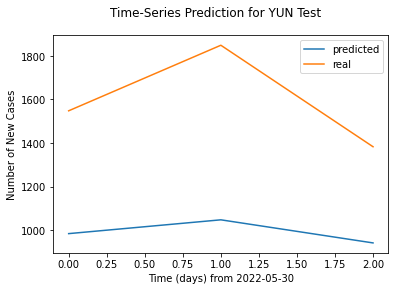

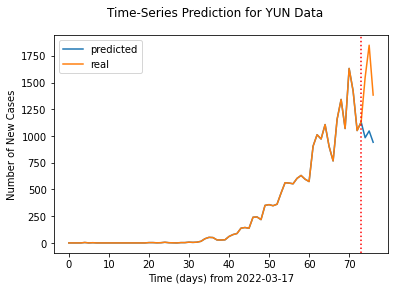

RMSE: 620.63
MAPE: 37.24%
===== CYQ =====
real & predicted test loss: 0.015421078773215413


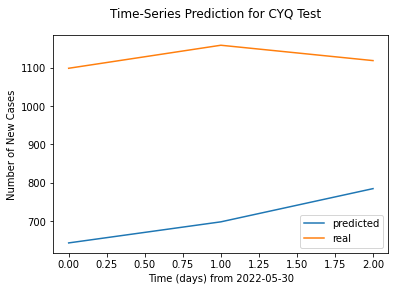

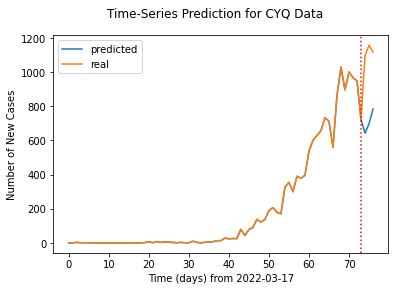

RMSE: 420.32
MAPE: 37.00%
===== CYI =====
real & predicted test loss: 0.0113002376165241


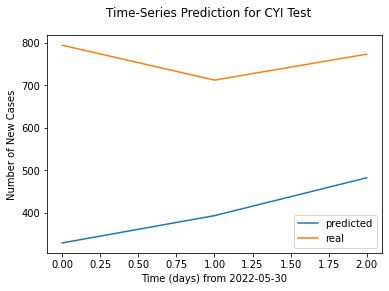

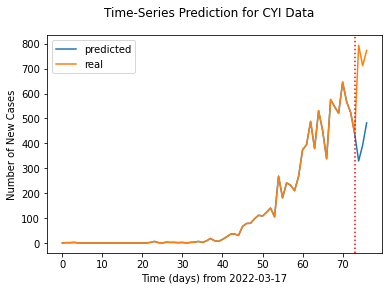

RMSE: 366.29
MAPE: 46.99%
===== TNN =====
real & predicted test loss: 0.0064806577283889055


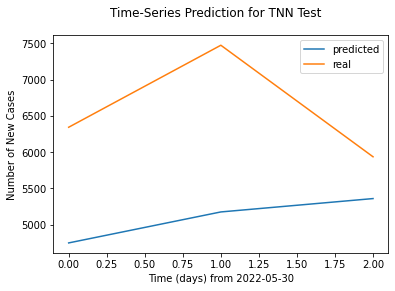

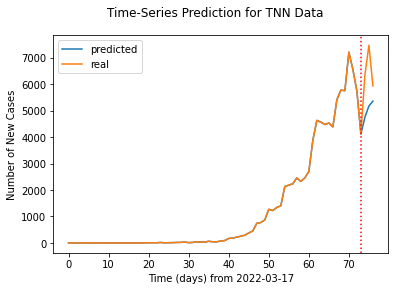

RMSE: 1648.07
MAPE: 21.86%
===== KHH =====
real & predicted test loss: 0.03447785973548889


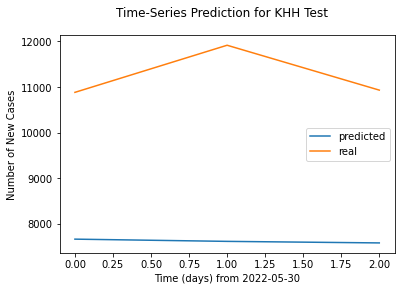

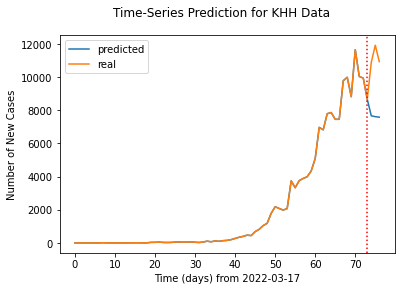

RMSE: 3658.53
MAPE: 32.13%
===== PIF =====
real & predicted test loss: 0.006390143418684602


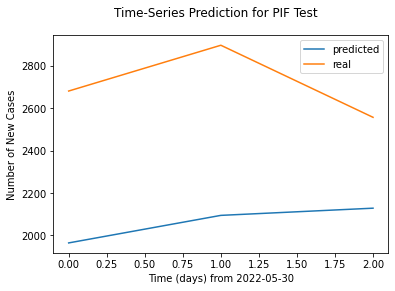

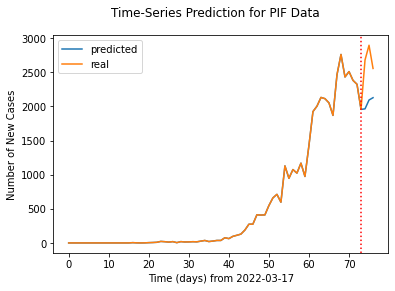

RMSE: 668.62
MAPE: 23.73%
===== ILA =====
real & predicted test loss: 0.01873344206251204


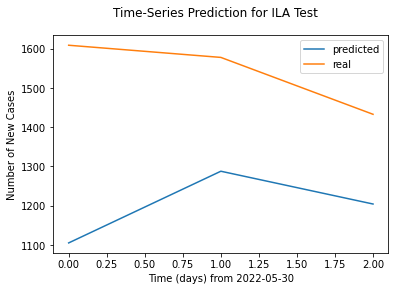

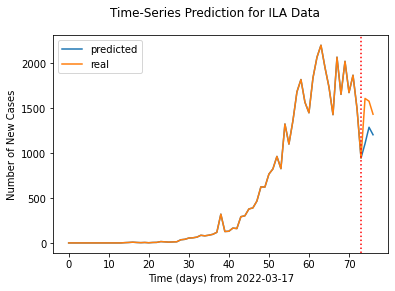

RMSE: 360.69
MAPE: 21.88%
===== HUA =====
real & predicted test loss: 0.020926923491060734


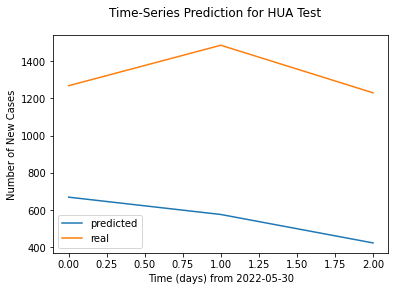

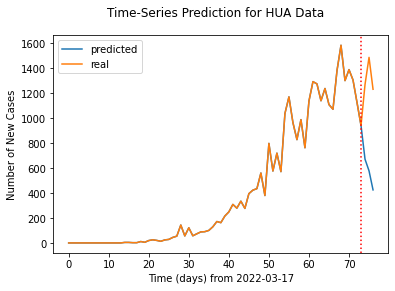

RMSE: 780.73
MAPE: 57.94%
===== TTT =====
real & predicted test loss: 0.006870672921650112


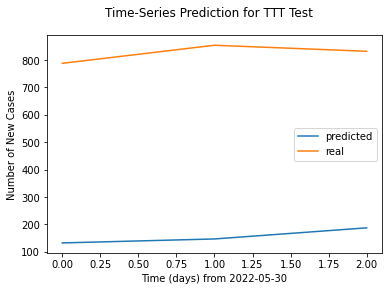

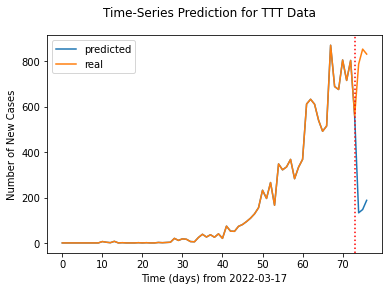

RMSE: 669.45
MAPE: 81.13%
===== PEN =====
real & predicted test loss: 0.02682124311104417


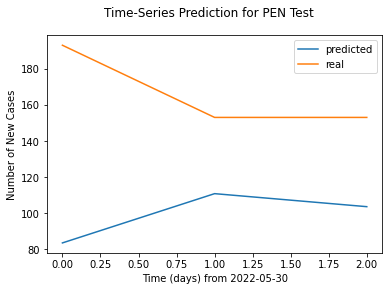

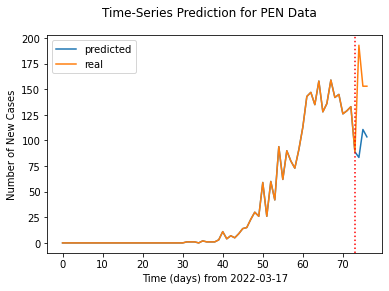

RMSE: 73.56
MAPE: 38.90%
===== KIN =====
real & predicted test loss: 0.0319050969555974


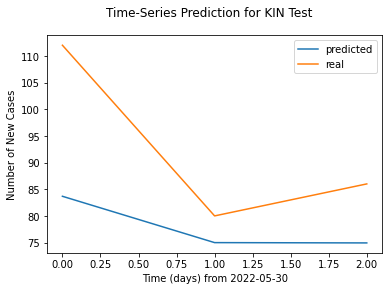

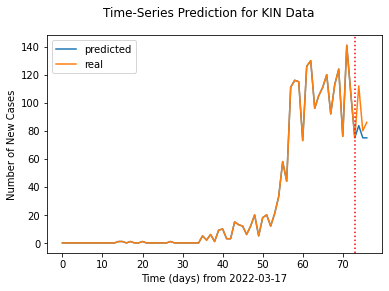

RMSE: 17.79
MAPE: 14.80%
===== LIE =====
real & predicted test loss: 0.006999121862463653


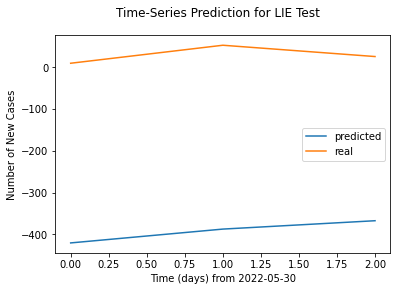

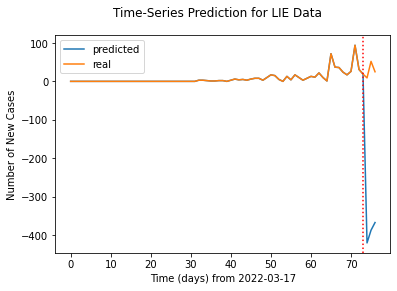

RMSE: 420.83
MAPE: 2394.99%


In [20]:
for city in city_codes:
    print(f"===== {city} =====")
    preprocData = cityWiseDataPreproc(cityWiseData, city, cityMapping[city])
    sc, dataX, dataY, _, trainY, _, _, testX, testY = data_preprocess(preprocData.values)
    input_size = preprocData.values.shape[1]
    num_classes = preprocData.values.shape[1]

    lstm = LSTM(num_classes, input_size, hidden_size, num_layers).to(device)
    ckpt = torch.load(save_path.format(city), map_location='cpu')
    lstm.load_state_dict(ckpt)
    
    # test set: real & predicted data -> predicted data
    _testX = testX[[0]].clone()
    total_loss = 0
    total_test_predict = []
    for i in range(testY.size(0)):
        test_predict, loss = test(city, lstm, _testX, testY[[i]])
        total_loss += loss
        total_test_predict.append(test_predict)
        # print(torch.unsqueeze(test_predict, 0).shape)

        # test_predict_arr = np.array([torch.squeeze(test_predict).item()]+[0]*(input_size-1))
        # print(test_predict_arr.shape)
        # print(test_predict_arr)
        # print(sc.inverse_transform(test_predict_arr[np.newaxis]))
        # test_predict_arr = sc.inverse_transform(test_predict_arr[np.newaxis])

        # print(minmaxNorm.inverse_transform(test_predict_arr))
        # test_predict_arr = minmaxNorm.inverse_transform(test_predict_arr)

        # print(_testX[:,1:].shape)
        _testX = torch.cat((_testX[:,1:], torch.unsqueeze(test_predict, 0)), 1)
    total_test_predict = torch.cat(total_test_predict)

    # 變動的feature數量需要特殊處理，e.g. 使用多個城市資料作為input
    numFeatOrigin = minmaxNorm.n_features_in_
    numFeatCascade = total_test_predict.data.numpy().shape[1]
    total_test_predict = total_test_predict.data.numpy()
    _testY = testY.data.numpy().copy()
    dataY = dataY.data.numpy()

    if numFeatCascade > numFeatOrigin:
      numCities = int(numFeatCascade/numFeatOrigin)
      for i in range(numCities):
        total_test_predict[:, i*numFeatOrigin:(i+1)*numFeatOrigin] = \
        minmaxNorm.inverse_transform(total_test_predict[:, i*numFeatOrigin:(i+1)*numFeatOrigin])
        _testY[:, i*numFeatOrigin:(i+1)*numFeatOrigin] = minmaxNorm.inverse_transform(_testY[:, i*numFeatOrigin:(i+1)*numFeatOrigin])
        dataY[:, i*numFeatOrigin:(i+1)*numFeatOrigin] = minmaxNorm.inverse_transform(dataY[:, i*numFeatOrigin:(i+1)*numFeatOrigin])
    else: 
      total_test_predict = minmaxNorm.inverse_transform(total_test_predict)
      _testY = minmaxNorm.inverse_transform(_testY)
      dataY = minmaxNorm.inverse_transform(dataY)

    # print(testY[:, 0])
    # print(trainY[-5:, 0])
    # print(_testY[:5, 0])
    print(f"real & predicted test loss: {total_loss}")
    plot_predict(city, "Test", total_test_predict[:, 0], _testY[:, 0], test_start_date)

    
    _dataY = np.copy(dataY)
    for i in range(testY.size(0)):
        _dataY[-test_size+i][0] = total_test_predict[i][0]
    plot_predict(city, "Data", _dataY[:, 0], dataY[:, 0], start_date_y)

    printPredError(total_test_predict[:, 0], _testY[:, 0])

    del lstm

## **Prediction for Long Term**

In [21]:
def pred_long(model, timeline_x):
    model.eval()
    _X = timeline_x.to(device)
    pred = model(_X)

    return pred.detach().cpu()

In [22]:
def plot_predict_long(city, pred, start_date):
    plt.plot(pred)
    plt.suptitle(f"Time-Series Prediction for {city}")
    plt.xlabel(f"Time (days) from {start_date}")
    plt.ylabel("Number of New Cases")
    plt.legend(("predicted"))
    plt.axvline(x=(train_size-1), c='red', linestyle=':')
    plt.show()

In [23]:
def save_pred(city, pred):
    with open(os.path.join('..', 'output', 'LSTM-multivariate', f'{city}.csv'), "w") as out_file:
        out_file.write("new_cases\n")
        np.savetxt(out_file, pred, fmt='%s', delimiter=',')

===== KEE =====


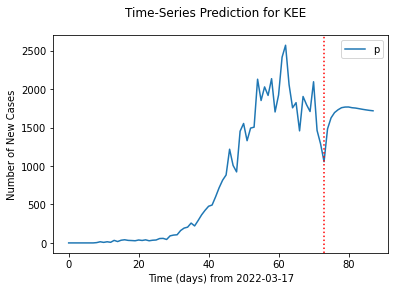

===== NWT =====


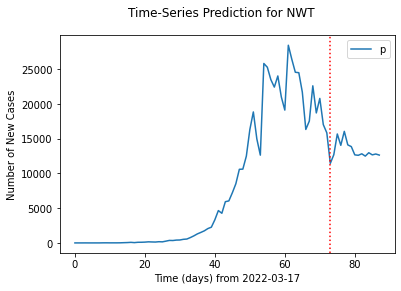

===== TPE =====


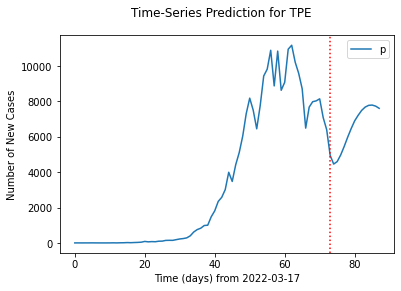

===== TAO =====


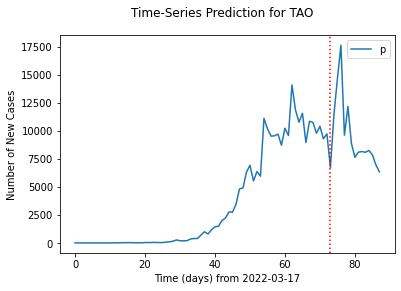

===== HSZ =====


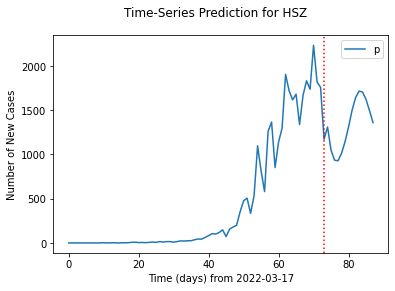

===== HSQ =====


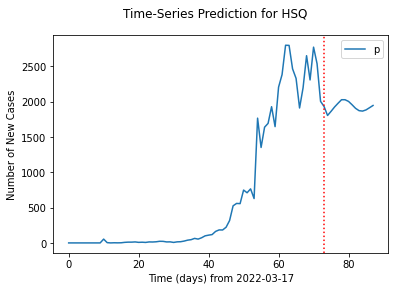

===== MIA =====


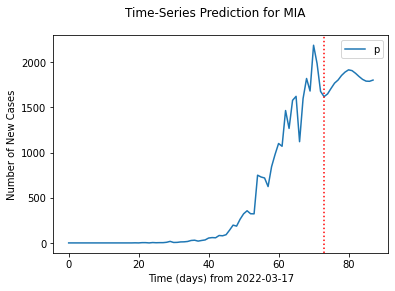

===== TXG =====


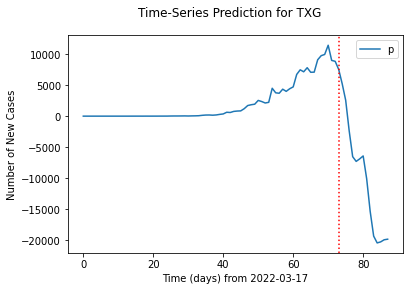

===== CHA =====


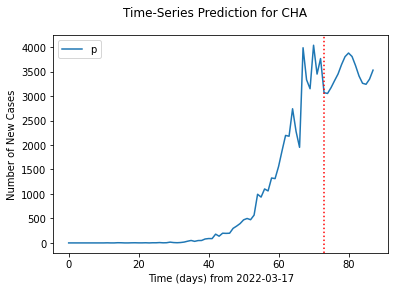

===== NAN =====


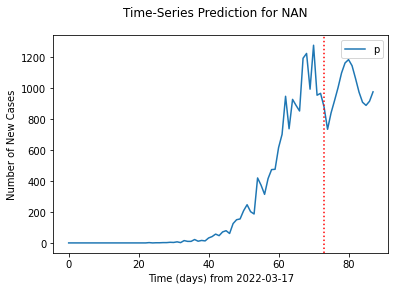

===== YUN =====


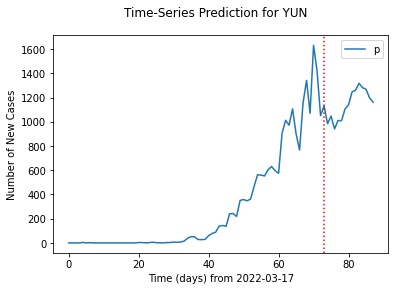

===== CYQ =====


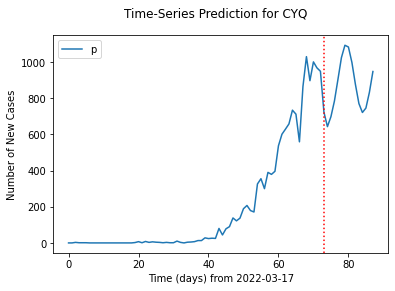

===== CYI =====


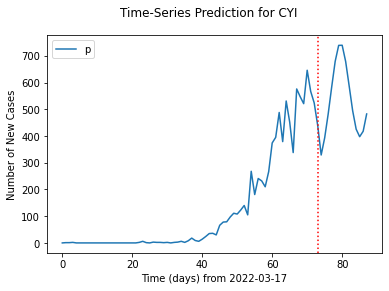

===== TNN =====


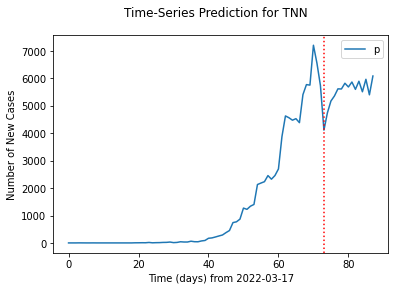

===== KHH =====


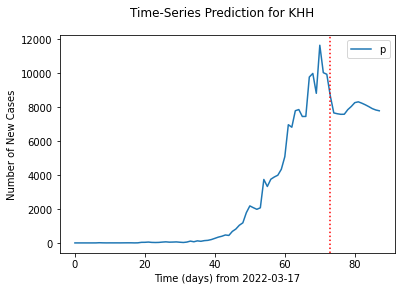

===== PIF =====


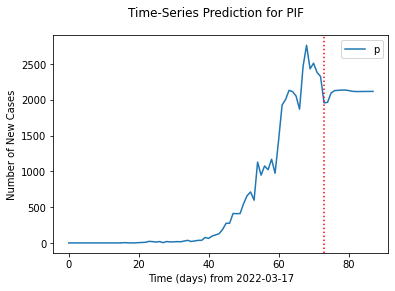

===== ILA =====


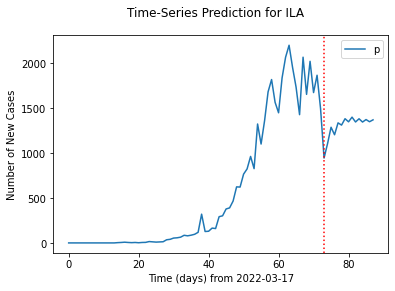

===== HUA =====


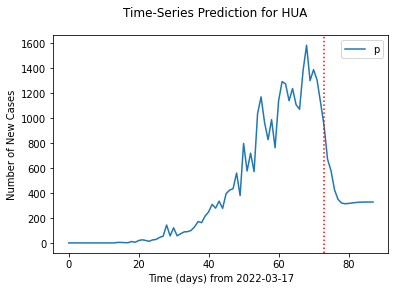

===== TTT =====


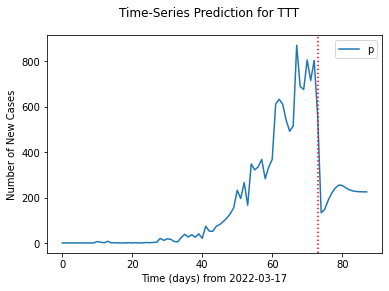

===== PEN =====


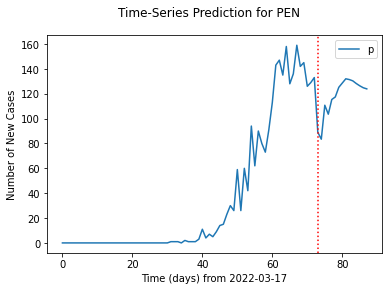

===== KIN =====


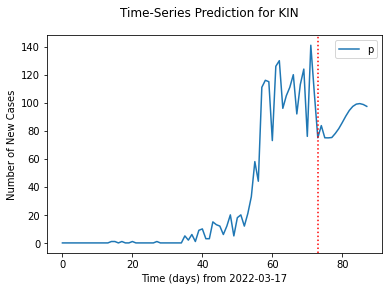

===== LIE =====


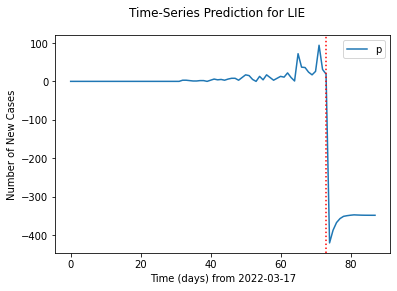

In [24]:
os.makedirs(os.path.join('..', 'output', 'LSTM-multivariate'), exist_ok=True)
for city in city_codes:
    print(f"===== {city} =====")
    preprocData = cityWiseDataPreproc(cityWiseData, city, cityMapping[city])
    sc, dataX, dataY, _, trainY, _, _, testX, testY = data_preprocess(preprocData.values)
    input_size = preprocData.values.shape[1]
    num_classes = preprocData.values.shape[1]

    lstm = LSTM(num_classes, input_size, hidden_size, num_layers).to(device)
    ckpt = torch.load(save_path.format(city), map_location='cpu')
    lstm.load_state_dict(ckpt)

    # test set: real & predicted data -> predicted data
    _testX = testX[[0]].clone()
    total_loss = 0
    total_test_predict = []
    for i in range(pred_long_size):
        test_predict = pred_long(lstm, _testX)
        total_test_predict.append(test_predict)
        _testX = torch.cat((_testX[:,1:], torch.unsqueeze(test_predict, 0)), 1)
    total_test_predict = torch.cat(total_test_predict)

    # 變動的feature數量需要特殊處理，e.g. 使用多個城市資料作為input
    numFeatOrigin = minmaxNorm.n_features_in_
    numFeatCascade = total_test_predict.data.numpy().shape[1]
    total_test_predict = total_test_predict.data.numpy()
    dataY = dataY.data.numpy()

    if numFeatCascade > numFeatOrigin:
      numCities = int(numFeatCascade/numFeatOrigin)
      for i in range(numCities):
        total_test_predict[:, i*numFeatOrigin:(i+1)*numFeatOrigin] = \
        minmaxNorm.inverse_transform(total_test_predict[:, i*numFeatOrigin:(i+1)*numFeatOrigin])
        dataY[:, i*numFeatOrigin:(i+1)*numFeatOrigin] = minmaxNorm.inverse_transform(dataY[:, i*numFeatOrigin:(i+1)*numFeatOrigin])
    else: 
      total_test_predict = minmaxNorm.inverse_transform(total_test_predict)
      dataY = minmaxNorm.inverse_transform(dataY)

    
    pred_y = np.copy(dataY)
    # print(pred_y)
    pred_y = pred_y[:-test_size, [0]]
    # print(pred_y)
    pred_y = np.append(pred_y, np.zeros((pred_long_size, 1)), 0)
    for i in range(pred_long_size):
        pred_y[-pred_long_size+i][0] = total_test_predict[i][0]
    plot_predict_long(city, pred_y, start_date_y)

    pred_y = np.rint(pred_y).astype(int)
    save_pred(city, pred_y)

    del lstm